# Pre-process and write to npz for GNN training and testing

In [67]:
import numpy as np
import glob
import json
import random
import math
import pathlib
       

dataset = 'Concrete3D'
in_dir = f'/home/jovyan/share/gns_data/Concrete3D/DYNA_one/'
out_dir = f'/home/jovyan/share/gns_data/{dataset}/'
pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)

STRAIN_MEAN, STRAIN_STD = 0.5426821307442955, 0.7741500060379738

# Grab all simulation cases from corresponding data folder
simulations = glob.glob(in_dir +'*')
random.shuffle(simulations)

## Larger step size leads to shorter trajectory and hence better rollout performance
## But lower precision of the simulation
## Current simulation are of absolute time 30 ms
## Step size=1 means 53 steps, each of which 0.6 ms
STEP_SIZE = 1

## Initialisation placeholders for data
n_trajectory = len(simulations)
ds_train, ds_valid, ds_test = {}, {}, {}
vels = np.array([]).reshape(0, 3)
accs = np.array([]).reshape(0, 3)
strain_stats = np.array([])
file_train, file_valid, file_test = [], [], []

## Main loop for data extraction
for idx, simulation in enumerate(simulations):
    print(f"{idx}/{n_trajectory} Reading {simulation}...")
    positions, particle_types, strains = parse_simulation(simulation)
    dim = positions.shape[-1]
    
    positions = positions[::STEP_SIZE, :, :]
    
    strains = strains[::STEP_SIZE, :]
    strains = (strains - STRAIN_MEAN) / STRAIN_STD   ## standardize based on overall mean and std
    
    # print for debug
    print(f"Dim: {dim}")
    print(f"Position min:{positions.min(axis=(0,1))}, max:{positions.max(axis=(0,1))}")
    print(f"Strain min:{strains.min(axis=(0,1))}, max:{strains.max(axis=(0,1))}")
    print(f"Shape, pos: {positions.shape}, types: {particle_types.shape}, strain: {strains.shape}")
    print(f"Unique particle types: {np.unique(particle_types)}")
    
    # Data splits: train(80%), valid(10%), test(10%)
    key = f'trajectory_{idx}' 
    if True:
        print('to valid')
        ds_valid[key] = [positions, particle_types, strains]
        file_valid.append(simulation)
    if True:
        print('to test')
        ds_test[key] = [positions, particle_types, strains]
        file_test.append(simulation)
    if True:
        print('to train')
        ds_train[key] = [positions, particle_types, strains]
        file_train.append(simulation)
        
    # Extract Vel and Acc statistics
    # positions of shape [timestep, particles, dimensions]
    vel_trajectory = positions[1:,:,:] - positions[:-1,:,:]
    acc_trajectory = vel_trajectory[1:,:,:]- vel_trajectory[:-1,:,:]
    
    vels = np.concatenate((vels, vel_trajectory.reshape(-1, dim)), axis=0)
    accs = np.concatenate((accs, acc_trajectory.reshape(-1, dim)), axis=0)

# Extract vel, acc statistics for normalisation
vel_mean, vel_std = list(vels.mean(axis=0)), list(vels.std(axis=0))
acc_mean, acc_std = list(accs.mean(axis=0)), list(accs.std(axis=0))

# Save datasets in numpy format
np.savez(out_dir + 'train.npz', **ds_train)
np.savez(out_dir + 'valid.npz', **ds_valid)
np.savez(out_dir + 'test.npz', **ds_test)

print(f"{len(ds_train)} trajectories saved to train.npz.")
print(f"{len(ds_valid)} trajectories saved to valid.npz.")
print(f"{len(ds_test)}  trajectories saved to test.npz.")

# Save meta data
in_file = '/home/jovyan/share/gns_data/Concrete2D-C/metadata.json'
out_file = f'/home/jovyan/share/gns_data/{dataset}/metadata.json'

with open(in_file, 'r') as f:
    meta_data = json.load(f)

# In GNN, the suggested connection radius is 4.5r, or 5.625 mm (aounrd 20 neighbors)
# If R is 5 mm before normalization, 
meta_data['dim'] = 3
meta_data['default_connectivity_radius'] = 15 
meta_data['sequence_length'] = positions.shape[0]
meta_data['vel_mean'] = vel_mean
meta_data['vel_std'] = vel_std
meta_data['acc_mean'] = acc_mean
meta_data['acc_std'] = acc_std
meta_data['strain_mean'] = STRAIN_MEAN
meta_data['strain_std'] = STRAIN_STD

meta_data['dt'] = 0.0006 * STEP_SIZE
meta_data['bounds'] = [[-10, 1710], [-20, 170], [-20, 430]]
meta_data['file_train'] = file_train
meta_data['file_valid'] = file_valid
meta_data['file_test'] = file_test
print(meta_data)

with open(out_file, 'w') as f:
    json.dump(meta_data, f)

0/1 Reading /home/jovyan/share/gns_data/Concrete3D/DYNA_one/42MPa_errosion...


/tmp/ipykernel_2371/2239062242.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trajectory = np.array(trajectory).astype(float)


ValueError: setting an array element with a sequence.

In [57]:
simulation = "/home/jovyan/work/gns/data/Concrete3D/DYNA/50MPa"

positions, particle_types, strains = parse_simulation(simulation)

pos: (53, 70866, 3) [ -0.04885495  -9.9152327  -14.233536  ] [1699.9838  159.7229  425.    ]
(70866,) 0.14133717156323203 0.48411050317001275 0 3
(53, 70866) 0.5219498179084072 0.7584077827783574 -0.0017086879 1.9985927


In [65]:
print('pos:', positions.shape, positions.min(axis=(0,1)), positions.max(axis=(0,1)))
print(np.unique(particle_types))
print(strains.shape, strains.mean(), strains.std(), strains.min(), strains.max())

pos: (53, 70866, 3) [ -0.04885495  -9.9152327  -14.233536  ] [1699.9838  159.7229  425.    ]
[0 1 2 3]
(53, 70866) -0.026780743620986813 0.979665151279681 -0.7032110242179497 1.8806569242399371


# Parse DYNA file to extact type, pos, strain (version 2 with which separate solid strain (eps) and beam strain (axs))

In [46]:
import re
import numpy as np
import random

re_int_sci = r'[-\d\.]+e?[-+\d]*'
re_sci = r'[+-]?\d+\.\d+e[+-]?[\d]+'

def parse_simulation(file):
    '''
    Extract info from LSDYNA txt, including 
        particle coordinates, 
        particle types, 
        solid strains (eps) and 
        beam strains (axs).
        
    Input: text file, e.g., 20MPa, 30Mpa. The text file is extracted with the following steps:
        1. Load d3plot file and unselect the parts 'weight' and 'load cell'
        2. Output the 'Element' for 'Active parts only' (particle type)
        3. Output 'Element Centroid, Volume' by appending all steps (pos)
        4. Further unselect parts 'long','hoop', select 'eps' and Output 'Element results' and append all (eps)
        5. Further unselect 'beam', 'head', select 'long' and 'hoop', select 'axial strain', and Output 'Element results' and append all (axs)
    
    Output: np arrays
            tracjectory: (timesteps, num_particles, 3), 
            particle_type: (num_particles,), 
            strains: (timesteps, num_particles).       
    '''
    
    with open(file, 'r') as f:
        lines = f.readlines()

    ## Concrete-2D-CI particle types based on particle index
    PID_TO_TYPE = {1:0,   # Beam
                   4:1,   # Head (same material with load cell)
                   5:2,   # Long
                   6:3    # Hoop
                  }

    pos_lines_start, end_lines = [], []
    solid_strain_lines_start, beam_strain_lines_start = [], []
    for idx, line in enumerate(lines):
        if line.startswith("*ELEMENT_SOLID"):
            type_line_start = idx
        elif line.startswith("$Eid, X, Y, Z, Volume"):
            pos_lines_start.append(idx)
        elif line.startswith("$RESULT OF Effective Plastic Strain (Unaveraged)"):
            solid_strain_lines_start.append(idx)
        elif line.startswith("$RESULT OF Axial Strain (Unaveraged)"):  
            beam_strain_lines_start.append(idx)
        elif line.startswith("*END"):  # $NODAL_RESULTS,(1d) *INITIAL_VELOCITY_NODE(2d)
            end_lines.append(idx)

    type_line_end = end_lines[0]    # the first *END is for particle type
    num_timesteps = len(pos_lines_start)
    pos_lines_end = end_lines[1:num_timesteps+1]
    solid_strain_lines_end = end_lines[num_timesteps+1:2*num_timesteps+1]
    beam_strain_lines_end = end_lines[2*num_timesteps+1:]

    # Extact particle types
    particle_types = []
    eids = []
    for line in lines[type_line_start:type_line_end]:
        num_str = re.findall(re_int_sci, line)  # Regular expression findign integers
        if len(num_str) >= 4:
            eid = int(num_str[0])
            pid = int(num_str[1])
            particle_type = PID_TO_TYPE[pid]
            eids.append(eid)
            particle_types.append((eid, particle_type))
    particle_types = np.array(particle_types).astype(int)

    # Extact particle positions 
    trajectory = []
    for line_start, line_end in zip(pos_lines_start, pos_lines_end):
        pos_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
        pos_one_step = []
        for line in pos_lines:
            num_str = re.findall(re_int_sci, line)  # Regular expression findign scitific numbers
            if len(num_str) >= 4:
                pos = [float(x) for x in num_str[:4]] # [eid, x, y, z]
                pos = tuple(pos)
                pos_one_step.append(pos)
        trajectory.append(pos_one_step) 
    trajectory = np.array(trajectory).astype(float)

    # Extract effective plastic strain for solids (eps)
    solid_strains = []
    for line_start, line_end in zip(solid_strain_lines_start, solid_strain_lines_end):
        strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
        strains_one_step = []
        for line in strain_lines:
            num_str = re.findall(re_int_sci, line)  # Regular expression findign scitific numbers
            if len(num_str) == 2:
                num = [float(x) for x in num_str]
                strains_one_step.append(tuple(num))
        solid_strains.append(strains_one_step)
    solid_strains = np.array(solid_strains).astype(float)

    # Extract axial strain for beams (axs)
    beam_strains = []
    for line_start, line_end in zip(beam_strain_lines_start, beam_strain_lines_end):
        strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
        strains_one_step = []
        for line in strain_lines:
            num_str = re.findall(re_int_sci, line)  # Regular expression findign scitific numbers
            if len(num_str) == 2:
                num = [float(x) for x in num_str]
                strains_one_step.append(tuple(num))
        beam_strains.append(strains_one_step)
    beam_strains = np.array(beam_strains).astype(float)

    # Concatenate solid and beam 
    strains = np.concatenate((solid_strains, beam_strains), axis=1)

    # Sort based on eid
    idx = particle_types[:, 0].argsort()
    particle_types = particle_types[idx, 1]

    idx = strains[0, :, 0].argsort()
    strains = strains[:, idx, 1]

    idx = trajectory[0, :, 0].argsort()
    trajectory = trajectory[:, idx, 1:]
    
    return trajectory, particle_types, strains


if __name__ == "__main__":
    pass

# Misc

## Modify metadata

In [140]:
in_file = '/home/jovyan/share/gns_data/Concrete3D/metadata.json'
out_file = f'/home/jovyan/share/gns_data/Concrete3D/metadata.json'

with open(in_file, 'r') as f:
    meta_data_in = json.load(f)

with open(out_file, 'r') as f:
    meta_data_out = json.load(f)

meta_data_out['dim'] = 3
meta_data_out['bounds'] = [[-5, 1705], [-40, 190], [-20, 700]]

for field in ['vel_mean', 'vel_std', 'acc_mean', 'acc_std']:
    meta_data_out[field] = meta_data_in[field]

print(meta_data_out)

with open(out_file, 'w') as f:
    json.dump(meta_data_out, f)

{'bounds': [[-5, 1705], [-40, 190], [-20, 700]], 'sequence_length': 53, 'default_connectivity_radius': 25, 'dim': 3, 'dt': 0.001, 'vel_mean': [0.0005337933448470438, 0.0018106315487202121, -0.11073433622830439], 'vel_std': [0.11112084584968404, 0.008962232631827051, 0.5942965257485089], 'acc_mean': [1.0318957818863562e-05, 3.406303359929661e-05, 0.011059929981645969], 'acc_std': [0.07041893840986731, 0.006486938060589395, 0.14354640411009972], 'file_train': ['/home/jovyan/share/gns_data/Concrete3D/DYNA/50MPa', '/home/jovyan/share/gns_data/Concrete3D/DYNA/30MPa', '/home/jovyan/share/gns_data/Concrete3D/DYNA/60MPa', '/home/jovyan/share/gns_data/Concrete3D/DYNA/20MPa', '/home/jovyan/share/gns_data/Concrete3D/DYNA/42MPa'], 'file_valid': ['/home/jovyan/share/gns_data/Concrete3D/DYNA/50MPa', '/home/jovyan/share/gns_data/Concrete3D/DYNA/30MPa', '/home/jovyan/share/gns_data/Concrete3D/DYNA/60MPa', '/home/jovyan/share/gns_data/Concrete3D/DYNA/20MPa', '/home/jovyan/share/gns_data/Concrete3D/DYNA

## Test regular expression for number extraction

In [61]:
import re

strs = ['20742   1.4952594e+03   -1.0499660e+02   1.6313647e-02   9.9995575e+02',
        '    32365   1.4051317e+00',
        '   10826       1   15757   15758   15784   15783   11311   11312   11338   11337',
        '$Total Solid element Volume =    7.5878880e+07'
       ]

pattern = r'[+-]?\d+\.\d+e[+-]?[\d]+'
for str in strs:
    print(re.findall(pattern, str))
    
pattern = r'[-\d\.]+e?[-+\d]*'
for str in strs:
    print(re.findall(pattern, str))

['1.4952594e+03', '-1.0499660e+02', '1.6313647e-02', '9.9995575e+02']
['1.4051317e+00']
[]
['7.5878880e+07']


## Parse LSDYNA file to extract particle coordinate, type, effective plastic strain

In [ ]:
import re
import numpy as np
import random

re_int_sci = r'[-\d\.]+e?[-+\d]*'   # find integer and scientific numbers
re_sci = r'[+-]?\d+\.\d+e[+-]?[\d]+'   # find scientific numbers only
file = '/home/jovyan/share/gns_data/Concrete3D/DYNA_one/42MPa_errosion'
    
## Concrete-2D-CI particle types based on particle index
PID_TO_TYPE = {1:0,   # Beam
               4:1,   # Head (same material with load cell)
               5:2,   # Long
               6:3    # Hoop
              }
    
with open(file, 'r') as f:
    lines = f.readlines()

pos_lines_start, end_lines = [], []
solid_strain_lines_start, beam_strain_lines_start = [], []
for idx, line in enumerate(lines):
    if line.startswith("*ELEMENT_SOLID"):
        type_line_start = idx
    elif line.startswith("$Eid, X, Y, Z, Volume"):
        pos_lines_start.append(idx)
    elif line.startswith("$RESULT OF Effective Plastic Strain (Unaveraged)"):
        solid_strain_lines_start.append(idx)
    elif line.startswith("$RESULT OF Axial Strain (Unaveraged)"):  
        beam_strain_lines_start.append(idx)
    elif line.startswith("*END"):  # $NODAL_RESULTS,(1d) *INITIAL_VELOCITY_NODE(2d)
        end_lines.append(idx)

type_line_end = end_lines[0]    # the first *END is for particle type
num_timesteps = len(pos_lines_start)
pos_lines_end = end_lines[1:num_timesteps+1]
solid_strain_lines_end = end_lines[num_timesteps+1:2*num_timesteps+1]
beam_strain_lines_end = end_lines[2*num_timesteps+1:]

# Extact particle types
particle_types = []
eids = []
for line in lines[type_line_start:type_line_end]:
    num_str = re.findall(re_int_sci, line)  # Regular expression findign integers
    if len(num_str) >= 4:
        eid = int(num_str[0])
        pid = int(num_str[1])
        particle_type = PID_TO_TYPE[pid]
        eids.append(eid)
        particle_types.append((eid, particle_type))
particle_types = np.array(particle_types).astype(int)

# Extact particle positions 
trajectory = []
for line_start, line_end in zip(pos_lines_start, pos_lines_end):
    pos_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
    pos_one_step = []
    for line in pos_lines:
        num_str = re.findall(re_int_sci, line)  # Regular expression findign scitific numbers
        if len(num_str) >= 4:
            pos = [float(x) for x in num_str[:4]] # [eid, x, y, z]
            pos = tuple(pos)
            pos_one_step.append(pos)
    trajectory.append(pos_one_step) 
trajectory = np.array(trajectory)

# Extract effective plastic strain for solids (eps)
solid_strains = []
for line_start, line_end in zip(solid_strain_lines_start, solid_strain_lines_end):
    strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
    strains_one_step = []
    for line in strain_lines:
        num_str = re.findall(re_int_sci, line)  # Regular expression findign scitific numbers
        if len(num_str) == 2:
            num = [float(x) for x in num_str]
            strains_one_step.append(tuple(num))
    solid_strains.append(strains_one_step)
solid_strains = np.array(solid_strains).astype(float)

# Extract axial strain for beams (axs)
beam_strains = []
for line_start, line_end in zip(beam_strain_lines_start, beam_strain_lines_end):
    strain_lines = lines[line_start+1:line_end]   # lines that contains positions in one time step
    strains_one_step = []
    for line in strain_lines:
        num_str = re.findall(re_int_sci, line)  # Regular expression findign scitific numbers
        if len(num_str) == 2:
            num = [float(x) for x in num_str]
            strains_one_step.append(tuple(num))
    beam_strains.append(strains_one_step)
beam_strains = np.array(beam_strains).astype(float)

# Concatenate solid and beam 
strains = np.concatenate((solid_strains, beam_strains), axis=1)

# Sort based on eid
idx = particle_types[:, 0].argsort()
particle_types = particle_types[idx, 1]

idx = strains[0, :, 0].argsort()
strains = strains[:, idx, 1]

idx = trajectory[0, :, 0].argsort()
trajectory = trajectory[:, idx, 1:]

In [174]:
# Extact particle positions 
trajectory, solid_strains, beam_strains, particle_typess = [], [], [], []
type_dict = dict(particle_types)
for idx in range(len(pos_lines_start)):
    line_start, line_end = pos_lines_start[idx]+1, pos_lines_end[idx]
    pos_lines = lines[line_start:line_end]
    line_start, line_end = solid_strain_lines_start[idx]+1, solid_strain_lines_end[idx]
    solid_strain_lines = lines[line_start:line_end]
    line_start, line_end = beam_strain_lines_start[idx]+1, beam_strain_lines_end[idx]
    beam_strain_lines = lines[line_start:line_end]
    
    # Extract axial strain for beams (axs)
    beam_strain_one_step = []
    for line in beam_strain_lines:
        beam_strain_str = re.findall(re_int_sci, line)
        if len(beam_strain_str) == 2:
            beam_strain_float = [float(x) for x in beam_strain_str] # [eid, axs]
            beam_strain_one_step.append(tuple(beam_strain_float))
    beam_strain_one_step = np.array(beam_strain_one_step).astype(float)
    #print('beam strain: ', beam_strain_one_step.shape)
    
    # Extract position for all particles
    pos_one_step, strain_one_step = [], []
    for pos_line in pos_lines:
        pos_str = re.findall(re_int_sci, pos_line)
        if len(pos_str) >= 4:
            pos_float = [float(x) for x in pos_str[:4]] # [eid, x, y, z]
            pos_one_step.append(tuple(pos_float))
    pos_one_step = np.array(pos_one_step)
    
    # Extract eps strain for solids (eps)
    for strain_line in solid_strain_lines:
        strain_str = re.findall(re_int_sci, strain_line)
        if len(strain_str) == 2:
            strain_float = [float(x) for x in strain_str] # [eid, eps]
            strain_one_step.append(tuple(strain_float))   
    strain_one_step = np.array(strain_one_step)
    
    pos_dict = {item[0]: item[1:] for item in pos_one_step}
    strain_dict = {item[0]: item[1:] for item in strain_one_step}
    
    for key in type_dict:
        if key not in pos_dict and type_dict[key] != 2 and type_dict[key] != 3:
            #print(idx, key, type_dict[key])
            pos_dict[key] = [0., 0., 0.]
            strain_dict[key] = [0.]
            type_dict[key] = 4
    pos_one_step_updated = np.array([[k] + list(v) for k, v in pos_dict.items()]).astype(float)
    strain_one_step_updated = np.array([[k] + list(v) for k, v in strain_dict.items()]).astype(float)
    particle_type_updated = np.array(list(type_dict.items())).astype(int)
    
    # print("pos: ", pos_one_step.shape)
    # print("strain: ", strain_one_step.shape)
    # print("pos updated: ", pos_one_step_updated.shape)
    # print("strain updated: ", strain_one_step_updated.shape)
    
    trajectory.append(pos_one_step_updated)
    solid_strains.append(strain_one_step_updated)
    particle_typess.append(particle_type_updated)
    beam_strains.append(beam_strain_one_step)
    
trajectory = np.array(trajectory).astype(float)
particle_typess = np.array(particle_typess).astype(int)
strains = np.concatenate((np.array(solid_strains), np.array(beam_strains)), axis=1).astype(float)

print('trajectory: ', trajectory.shape)
print('particle_types: ', particle_typess.shape)
print('strains :', strains.shape)

# Sort based on eid
for step in range(num_timesteps):
    sorted_idx = particle_typess[step, :, 0].argsort()
    particle_typess[step, :] = particle_typess[step, sorted_idx]

    sorted_idx = strains[step, :, 0].argsort()
    strains[step, :] = strains[step, sorted_idx]
    
    sorted_idx = trajectory[step, :, 0].argsort()
    trajectory[step, :] = trajectory[step, sorted_idx]

trajectory:  (53, 70866, 4)
particle_types:  (53, 70866, 2)
strains : (53, 70866, 2)


ValueError: could not broadcast input array from shape (70866,) into shape (70866,2)

In [176]:
num_timesteps = particle_typess.shape[0]
for step in range(num_timesteps):
    sorted_idx = particle_typess[step, :, 0].argsort()
    particle_typess[step, :] = particle_typess[step, sorted_idx]

    sorted_idx = strains[step, :, 0].argsort()
    strains[step, :] = strains[step, sorted_idx]
    
    sorted_idx = trajectory[step, :, 0].argsort()
    trajectory[step, :] = trajectory[step, sorted_idx]

In [185]:
trajectory = trajectory[:, :, 1:]
strains = strains[:, :, 1]
particle_typess = particle_typess[:,:,1]

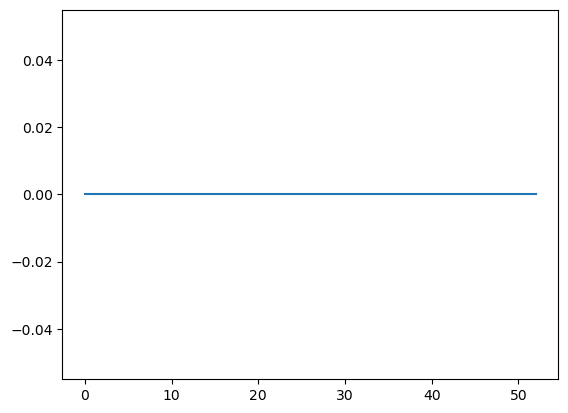

In [205]:
import matplotlib.pyplot as plt

plt.plot(strains[:, 51500])